# Hands-On 1: Audio Feature Extraction

For this first hands-on session, we are going to investigate the extraction of audio features. This is the first step for designing a classification model (in future hands-on sessions). <br>
As the recording of audio signals using a microphone will also be covered in a future hands-on session, we will start here by using sounds available in the ``ESC-50`` dataset.
> Karol J. Piczak, 2015, "ESC: Dataset for Environmental Sound Classification"  
> https://doi.org/10.7910/DVN/YDEPUT, Harvard Dataverse, V2 ([Available here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/YDEPUT))

Useful functions to select, read and play the dataset sounds are provided in the ``utils`` folder. The following required packages should be installed:
- soundfile
- scipy
- sounddevice
- librosa
- seaborn

You can install them with ``!pip install <packagename>`` (decomment the lines in the following cell). In case of an error with the utils folder (folder not found), you may need to launch Jupyter with the directory where the code to execute is located. To do so, open the Anaconda Prompt (if you are using Anaconda) and type ``jupyter notebook --notebook-dir=$YOUR PATH$``. <br>

To ensure you are catching the content of this notebook, we leave you with an infinitesimal amount of **code to write**. 

You will find the zones to be briefly filled  with a ``### TO COMPLETE`` in the cells below.

In [1]:
### UNCOMMENT THE FOLLOWING LINE TO INSTALL THE PACKAGES!<
#!python -m pip install numpy==1.22 scipy soundfile sounddevice pygame librosa seaborn

import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy import signal
import sounddevice as sd
import librosa # For audio signal computations as MFCC
from scipy.fftpack import dct

"Self created functions"
from utils_ import getclass, getname, gen_allpath, plot_audio, plot_specgram

We then create a matrix with path names of height H=50 classes and W=40 sounds per class. This will give you simple access to any sound from the dataset.

In [2]:
### TO COMPLETE
path2dataset = "ESC-50"

classnames, allpath = gen_allpath(folder=path2dataset) # Note: this function contains an implicit input "folder", where you can change the path to ESC-50 dataset.
print('The classes are : \n')
for ind, elem in enumerate(classnames) :
    print(ind, elem)

The classes are : 

0 Dog
1 Rooster
2 Pig
3 Cow
4 Frog
5 Cat
6 Hen
7 Insects
8 Sheep
9 Crow
10 Rain
11 Sea waves
12 Crackling fire
13 Crickets
14 Chirping birds
15 Water drops
16 Wind
17 Pouring water
18 Toilet flush
19 Thunderstorm
20 Crying baby
21 Sneezing
22 Clapping
23 Breathing
24 Coughing
25 Footsteps
26 Laughing
27 Brushing teeth
28 Snoring
29 Drinking
30 Door knock
31 Mouse click
32 Keyboard typing
33 Door
34 Can opening
35 Washing machine
36 Vacuum cleaner
37 Clock alarm
38 Clock tick
39 Glass breaking
40 Helicopter
41 Chainsaw
42 Siren
43 Car horn
44 Engine
45 Train
46 Church bells
47 Airplane
48 Fireworks
49 Hand saw


You can now select a sound from a given class using ``allpath[class_index,sound_index]``. For example, the first sound of the ``Cow`` class is accessed with ``allpath[3,0]`` (note that this index may change from one operating system to the other) and the following cell plays the sound:

In [3]:
sound = allpath[0,25]
x, fs = sf.read(sound)
target_dB = 25
x /= np.linalg.norm(x)*10**(-target_dB/20)
print(f"Playing a \"{getclass(sound)}\"")
sd.play(x, fs)

Playing a " Dog"


We now ask you to complete the cells below.

## 1) Resampling and filtering

Most probably your circuit board will sample the analog audio signal at a frequency $f_s = 11025$ Hz. <br>
However, the audio provided in the ``ESC-50`` dataset are sampled with $f_s = 44100$ Hz, you should thus downsample each audio signal to keep coherency with your real setup. There are 2 solutions:
- Rewrite a new dataset with the downsampled audio signals.
- Downsample each audio which is read.

We provide you with the second one.

***
#### <u> The following derivations are not necessary for the rest of this notebook, but are still provided for the curious students... </u>

Let us consider one original audio signal from the dataset and denote it $x[n]$, for $n=0,\dots,N-1$.

The downsampled signal $y$ can be written as 

$$
    y[m] = w[mM],\quad \text{with}\ w[k] = (h \ast x)[k] = \sum_{n=-\infty}^{\infty} h[n]x[k-n],
$$

where $h$ is a discrete low-pass filter and $M$ is the downsampling factor, here $M=4$. <br>

We can expand both $y$ and $w$ according to their Fourier series (DTFT) $Y$ and $W$, respectively, so that:

$$
    y[m] = \frac{1}{2\pi} \int_0^{2\pi} Y(e^{j\Omega}) e^{jm\Omega} d\Omega \tag{1}
$$
$$
    w[mM] = \frac{1}{2\pi} \int_{0}^{2\pi} W(e^{j\Omega}) e^{jmM\Omega} d\Omega = \frac{1}{2\pi} \sum_{k=0}^{M-1} \int_{2\pi k/M}^{2\pi(k+1)/M} W(e^{j\Omega}) e^{jmM\Omega} d\Omega \tag{2}
    $$

Regarding $w$, applying the change of variable $\Omega \leftarrow \Omega-2\pi k/M$ to each integral of the sum, and changing $k \leftarrow M - k$, we can further write

$$
   \textstyle w[mM] = \frac{1}{2\pi} \int_0^{2\pi/M} \sum_{k=0}^{M-1} W[e^{j(\Omega - 2\pi k/M)}] e^{jmM\Omega} d\Omega.
$$


With a final change of variable $\Omega \leftarrow M\Omega$, we get
$$
    \textstyle w[mM] = \frac{1}{2\pi} \int_0^{2\pi} \frac{1}{M} \sum_{k=0}^{M-1} W[e^{j(\Omega - 2\pi k)/M}] e^{jm\Omega} d\Omega.
$$

And by identifying (1) and (2), this yields:
$$
    Y(e^{j\Omega}) = \frac{1}{M} \sum_{k=0}^{M-1} W[e^{j(\Omega -2\pi k)/M}]
$$

***

In practice, here is the observed phenomenon when downsampling the spectrum above with factor $M=2$.

<center> <img src="images/downsampling.png" alt=""  width="600" height="300"/> </center>

Playing and showing data for :  205 - Chirping birds/2-72547-A.ogg
Downsampling factor:  4


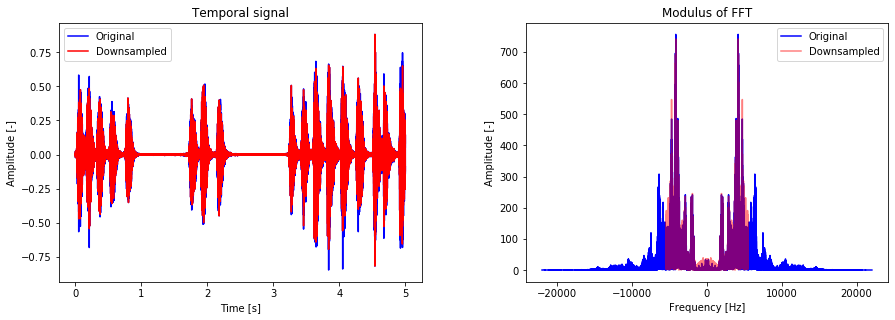

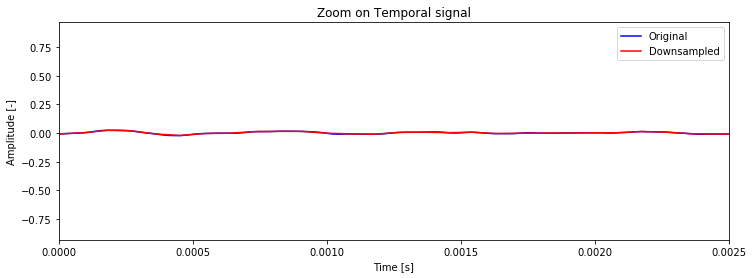

In [13]:
fs_down = 11025              # Target sampling frequency
sound = allpath[14,29]       # Sound choice (default should be Shirping Birds)  

print('Playing and showing data for : ', getname(sound) )
x, fs = sf.read(sound)

M = fs//fs_down # Downsampling factor
print('Downsampling factor: ', M)

### TO COMPLETE
### Downsample "audio"
x_naive_down = []
for i in range(0, len(x), M):
    x_naive_down.append(x[i])
#librosa.resample(x, fs, fs_down)


plot_audio(x,x_naive_down,fs,fs_down) # Function 

"""
we can see that when we downsample the signal naively, the downsample signal doen't "fit" on the full signal. On the frequecy
diagram, we can also see that we "created" new frequencies, and changed the amplitude of others. This is because the 
downsampling is done in such a way that several different signals could fit on the samples sampled, wich means that ther
are more than one Fourier transform for the downsampled signal. We then have to chose one of them, and this is not 
necessarily the right one (usualy we will chose the lower frequency), as we can see on the frequency graph. This is called aliasing


"""

Is your downsampling working properly in the time domain (verify using the zoom on the temporal signal)? What can you observe on the spectrum of the downsampled signal? How is this phenomenon named and what is its origin?

In order to avoid it, the original signal should be low-pass filtered prior to downsampling (as presented in the mathematics above).

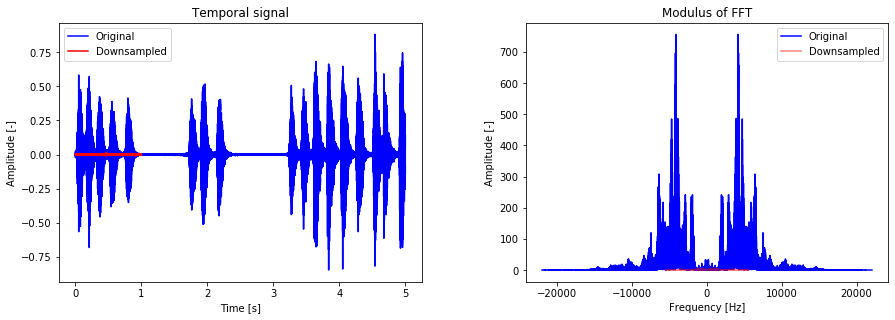

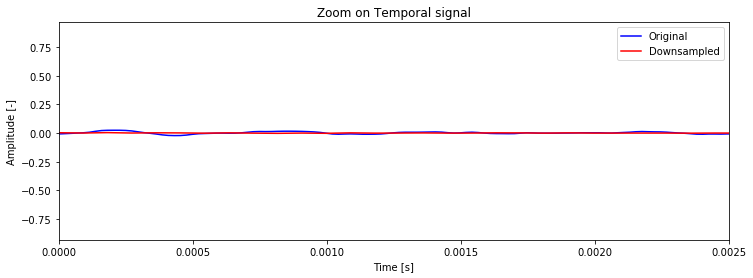

In [12]:
"Low-pass filtering before downsampling"
N = 100 # number of taps
taps = signal.firwin(numtaps=N, cutoff=fs_down/2, window='hamming', fs=fs)
x_filt = np.convolve(x,taps,mode='full')

### TO COMPLETE
### Downsample ``audio_filt``
x_filt_down = signal.resample(x, fs_down)

plot_audio(x,x_filt_down,fs,fs_down)

The obtained spectrum of the downsampled signal should not suffer from aliasing anymore. In fact, there is a built-in function in ``scipy.signal`` that performs the downsampling, including a low-pass filter: ``scipy.signal.resample``. Its docstring is:

In [6]:
help(signal.resample)

Help on function resample in module scipy.signal.signaltools:

resample(x, num, t=None, axis=0, window=None)
    Resample `x` to `num` samples using Fourier method along the given axis.
    
    The resampled signal starts at the same value as `x` but is sampled
    with a spacing of ``len(x) / num * (spacing of x)``.  Because a
    Fourier method is used, the signal is assumed to be periodic.
    
    Parameters
    ----------
    x : array_like
        The data to be resampled.
    num : int
        The number of samples in the resampled signal.
    t : array_like, optional
        If `t` is given, it is assumed to be the sample positions
        associated with the signal data in `x`.
    axis : int, optional
        The axis of `x` that is resampled.  Default is 0.
    window : array_like, callable, string, float, or tuple, optional
        Specifies the window applied to the signal in the Fourier
        domain.  See below for details.
    
    Returns
    -------
    resampled_x 

In the following, we use this function.

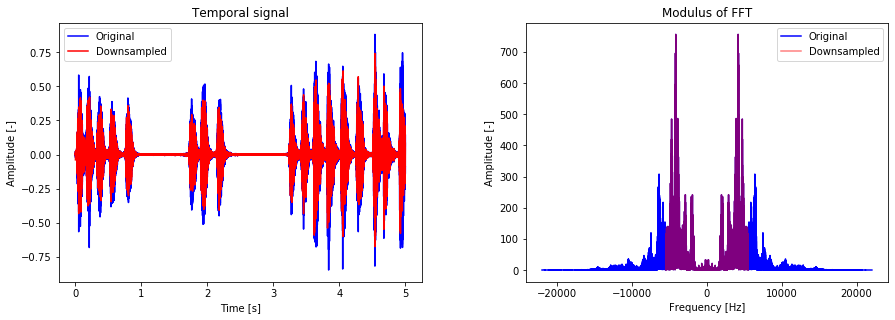

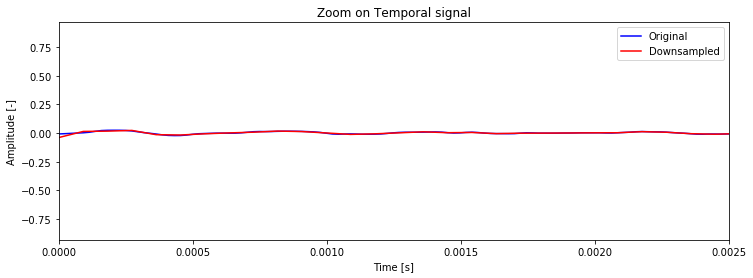

In [7]:
y = signal.resample(x, int(len(x)/M))
L = len(y)

plot_audio(x,y,fs,fs_down)

Can you hear the differences between the downsampled versions of the audio signal and the original one?

In [42]:
target_dB = 25
x /= np.linalg.norm(x)*10**(-target_dB/20)
sd.play(x, fs, blocksize=1024)
# sd.play(x_naive_down, fs_down, blocksize=1024)
# sd.play(x_filt_down, fs_down, blocksize=1024)
# sd.play(y, fs_down, blocksize=1024)

You can also try sounds from different classes by running again the code above and changing the choice of the variable ``sound``.

Now we are working with sound signals with same sampling frequency as for the project, we can go on.

## 2) Windowing and spectrogram computation

A very intuitive way to represent an audio signal is with a time-frequency analysis. 
The spectrogram of a signal consists in applying an FFT on successive subpieces of it, and thus obtaining a spectral content evolving with time.

Find an illustration of the idea here below.

<center> <img src="images/sound2fv.svg" alt="" height="500"/> </center>

Note: You can eventually add a "+1" in the "np.log" to get positive dB. This will look differently.


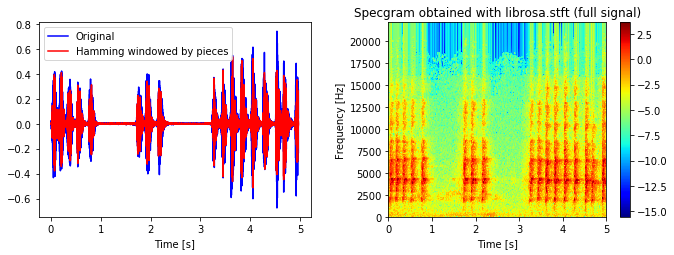

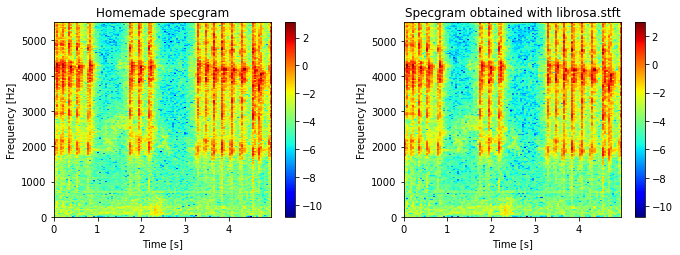

In [8]:
Nft = 512 # Number of samples by FFT

# Homemade computation of stft
"Crop the signal such that its length is a multiple of Nft"
y = y[:L-L%Nft]
L = len(y)
"Reshape the signal with a piece for each row"
audiomat = np.reshape(y, (L//Nft,Nft))
audioham = audiomat*np.hamming(Nft) # Windowing. Hamming, Hanning, Blackman,..
z = np.reshape(audioham,-1) # y windowed by pieces
"FFT row by row"
stft = np.fft.fft(audioham, axis=1)
stft = np.abs(stft[:,:Nft//2].T) # Taking only positive frequencies and computing the magnitude

"Library Librosa computing stft"
stft2 = librosa.stft(x, n_fft=Nft, hop_length=Nft, window='hamm', center='False') # without downsampling the signal
stft4 = np.abs(librosa.stft(z, n_fft=Nft, hop_length=Nft, window='hamm', center=False))

print("Note: You can eventually add a \"+1\" in the \"np.log\" to get positive dB. This will look differently.")

"Plots"
fig = plt.figure(figsize=(9, 3))
ax1 = fig.add_axes([0.0, 0.0, 0.42, 0.9])
ax2 = fig.add_axes([0.54, 0.0, 0.42, 0.9])

ax1.plot(np.arange(L)/fs_down, y, 'b', label='Original')
ax1.plot(np.arange(L)/fs_down, z, 'r', label='Hamming windowed by pieces')
ax1.set_xlabel('Time [s]')
ax1.legend()

plot_specgram(np.log(np.abs(stft2)), ax2, title='Specgram obtained with librosa.stft (full signal)', tf=len(x)/fs)
plt.show()

"Comparing the spectrograms" 
fig2 = plt.figure(figsize=(9, 3))
ax3 = fig2.add_axes([0.0, 0.0, 0.42, 0.9])
ax4 = fig2.add_axes([0.54, 0.0, 0.42, 0.9])
plot_specgram(np.log(np.abs(stft)), ax3, title='Homemade specgram', tf=len(y)/fs_down)
plot_specgram(np.log(np.abs(stft4)), ax4, title='Specgram obtained with librosa.stft', tf=len(y)/fs_down)
plt.show()
"""
When we look at the different spectrograms, we can see that for the ones à the bottom, we only kept the frequecies between 
0 and 5000Hz, while for the one on top, we kept the full range of frequencies. This is useful for several reasons,
the first one being that you only keep the interesting frequencies (the ones the human ear can hear well), and thus save 
memory. The second one is that you have a better resolution on the one with a reduce frequency range. This is cause by
the fact that the range of amplitude of the different signal is smaller (in the full spectogram, the amplitude goes 
from -15 from 2.5 while the cropted one go from -10 to 2), which allows you to see the differencies better

What differences can you notice between the upper spectrogram and the two others at the bottom?

<u> Remark:</u> Although the spectrograms obtained with the homemade version and the librosa library look similar, trying to compute and show their difference will not work. Indeed, there are subtle differences in the computation process of ``librosa.stft``, a slightly different window, frames which are computed are different as well. The priority for you is that the energy distribution in time and frequency remains similar, qualitatively speaking. This issue will be handled in the classification model.  

## 3) From Hz to Melspectrogram

Now we have done the major part of the job. But recall that this information will have to be transmitted wirelessly from your circuit board (transmitter) to a base station (receiver). It is thus good practive to try synthetizing a bit the content of this spectrogram. <br>

A popular approach is to transform the frequency axis from Hz to Mel unit. The intuition behind this transformation is that the human ear will more easily distinguish between $100$ and $200$ Hz than between $3000$ and $3100$ Hz. So higher frequencies are more likely to be put together in very fewer coefficients. <br>

This last step will thus consist in replacing each column of the spectrogram ``stft`` with size $N_{FT}$ by a shorter column with size $N_{mel} \ll N_{FT}$. To do so, we will use an Hz to Mel (``Hz2Mel``) transformation matrix provided by ``librosa``, and apply a matrix multiplication for each column.

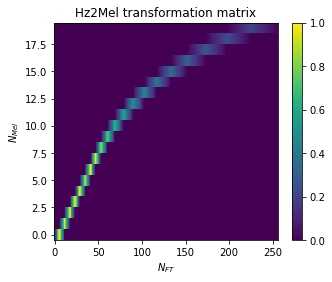

In [9]:
Nmel = 20

"Obtain the Hz2Mel transformation matrix" 
mels = librosa.filters.mel(sr=fs_down, n_fft=Nft, n_mels=Nmel)
mels = mels[:,:-1]

### TO COMPLETE
### Normalize the mels matrix such that its maximum value is one.
maxvalue = np.amax(mels)
mels = mels/maxvalue

"Plot"
plt.figure(figsize=(5,4))
plt.imshow(mels, aspect='auto', origin='lower')
plt.colorbar()
plt.title('Hz2Mel transformation matrix')
plt.xlabel('$N_{FT}$')
plt.ylabel('$N_{Mel}$')
plt.show()

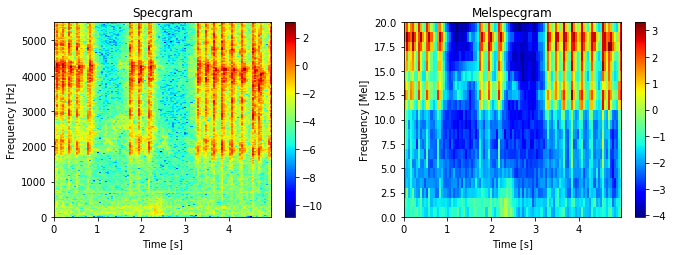

In [15]:
"Melspectrogram computation"
### TO COMPLETE
###  Perform the matrix multiplication between the Hz2Mel matrix and stft.
melspec = mels@stft
"Plot" 
fig = plt.figure(figsize=(9, 3))
ax1 = fig.add_axes([0.0, 0.0, 0.42, 0.9])
ax2 = fig.add_axes([0.54, 0.0, 0.42, 0.9])
plot_specgram(np.log(np.abs(stft)), ax=ax1, title='Specgram', tf=len(y)/fs_down)
plot_specgram(np.log(np.abs(melspec)), ax=ax2, is_mel=True, title='Melspecgram', tf=len(y)/fs_down)
plt.show()
"""
The two spectograms look similar. In the example we chose, we can see that the melspectogram is more "pixelised" 
due to less resolution. The frequency go upon 5000 in the first one but only goes to 20 in the second one. 
As there is less data in the second graph, it is more economic and the gain is about 5000/20 = 250
"""

Do these two spectrogram look similar? :) <br> 
What is the gain in the number of coefficients?

## 4) Creating black boxes

Now you have seen how to make the computations. <br>
A universal procedure consists in writing functions that will serve as working blocks and hide the computation details.
We can then gradually increase the abstraction. <br>

As any programmer should do, you are strongly encourage to ``fill your functions with a clear and concise docstring``. This will help you later this year when you will want to make improvements to some parts of your code. <br>

**Remark**: In any hands-on session you will work on during this semester, you will be provided with some already implemented code to exploit for processing and visualisation.
The implemented code will sometimes have been written by the teaching staff in the most readable and modular way possible. However, this may happen you want to add some features or simply modify some functions. Feel free to do so. In general, you can modify anything as you wish. Even the Python packages!

In [16]:
def resample(x, M=4):
    """   Downsamples the signal X at a M factor
   
    Inputs
      x:  float array, signal to be resampled
      M:  int, resample factor
    Outputs
      y:  float array with size len(x)/M, function resampled

    """
    y = signal.resample(x, int(len(x)/M))
   
    return y

def specgram(y, Nft=512):
    """  
    Computes the spectrogram of y
    
    Inputs
      y:  float array, signal which the stft will be computed on
      Nft:  int, Number of samples by FFT

    Outputs
      stft:   float array, the stft computed

    """
   
    "Crop the signal such that its length is a multiple of Nft"
    if (y.ndim==2): #checking if the sound is stereo or mono, and chossing only one chanel
        y=y[:,0]
    L = len(y)
    y = y[:L-L%Nft]
    L = len(y)
    "Reshape the signal with a piece for each row"
    audiomat = np.reshape(y, (L//Nft,Nft))
    audioham = audiomat*np.hamming(Nft) # Windowing. Hamming, Hanning, Blackman,..
    z = np.reshape(audioham,-1) # y windowed by pieces
    "FFT row by row"
    stft = np.fft.fft(audioham, axis=1)
    stft = np.abs(stft[:,:Nft//2].T) # Taking only positive frequencies and computing the magnitude

    return stft


def melspecgram(x, Nmel=20, Nft=512, fs=44100, fs_down=11025):
    """   
    Computes the melspectrogram of x
   
    Inputs
      x:  float array, sound signal [type, size, description]
      Nmel: int, ratio [type, size, description]
      Nft:  int, Number of samples by FFT [type, size, description]
      fs: int, original sampling frequency
      fs_down:  int, Target sampling frequency

    Outputs
      melspec: array of arrays of floats [type, size, description]

    """
   
    ### TO COMPLETE, using the functions resample() and specgram() defined above
    y = resample(x, M=4)
   
    stft = specgram(y, Nft)
   
    mels = librosa.filters.mel(sr=fs_down, n_fft=Nft, n_mels=Nmel)
    mels = mels[:,:-1]

    maxvalue = np.amax(mels)
    mels = mels/maxvalue

    melspec = mels@stft
   
    return melspec




## 5) Show us your skills
You are now encouraged to apply the functions you created above to sounds from at least 3 different classes. Observe their spectrograms and comment. Is it easy to differentiate sounds from the classes you chose?

Note: Notice that here we added the "+1" for the visualization!


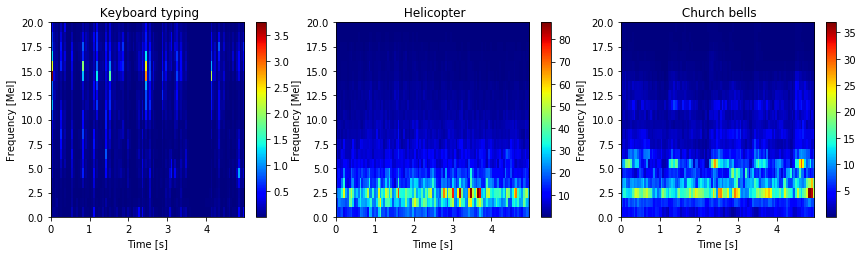

In [17]:
### TO COMPLETE
### Choose 3 sounds from different classes to observe how their mel spectrograms differ
sound1 =  allpath[32,25]
sound2 =  allpath[40,25]
sound3 =  allpath[46,25]

"Compute the melspecgrams"
x1, _ = sf.read(sound1)
x2, _ = sf.read(sound2)
x3, _ = sf.read(sound3)
melspec1 = melspecgram(x1)
melspec2 = melspecgram(x2)
melspec3 = melspecgram(x3)

print("Note: Notice that here we added the \"+1\" for the visualization!")

"Plot"
fig = plt.figure(figsize=(12, 3))
ax1 = fig.add_axes([0.0, 0.0, 0.28, 0.9])
ax2 = fig.add_axes([0.33, 0.0, 0.28, 0.9])
ax3 = fig.add_axes([0.66, 0.0, 0.28, 0.9])
plot_specgram(melspec1, ax=ax1, is_mel=True, title=getclass(sound1), tf=len(y)/fs_down)
plot_specgram(melspec2, ax=ax2, is_mel=True, title=getclass(sound2), tf=len(y)/fs_down)
plot_specgram(melspec3, ax=ax3, is_mel=True, title=getclass(sound3), tf=len(y)/fs_down)
plt.show()



### Question:
Briefly comment what is intuitive for you in the content of these 3 spectrograms respectively with the corresponding classes.
How can you differentiate them?

In [ ]:
### TO COMPLETE
# Answer the questions above
"""
We answered to the questions above directly after the question in the NoteBook

We can see, in the examples we chose that the most important parts of the spectrum are highlighted and 
well-definied because of the filter and the resampling. The majority of the spectrum is negligeable (dark blue). 
Because of that, we can directly distinguish the sounds. For example, the church bell and the helicopter have 
similarities in the spectogram but we can see that the church bells are more noisy regarding different frequencies 
represented by the different shades of color other than dark blue.

"""